# Sentiment Analysis of French Tweets

The task in this project is to develop a machine learning model to classify tweets in french language. One of the challenges here is to deal with particularities of the french language which is not part of the default setting of most ML libraries.

The dataset consists of text from tweets in french and integer where 1 represents positive sentiment and 0 represents negative sentiment. The dataset file contains around 1.5 millions tweets. In this project the dataset is reduced to 400 000 samples to deal with the RAM limitations. 

## Modules import and downloads

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 

import os
import collections

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, Embedding, Activation, Bidirectional, Dropout, LSTM

from sklearn.model_selection import train_test_split
import string
import gc
from keras.utils import plot_model

In [3]:
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git &> /dev/null

In [4]:
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
french_stopwords = nltk.corpus.stopwords.words('french')
mots = set(line.strip() for line in open('/content/drive/MyDrive/data/dictionnaire.txt'))
lemmatizer = FrenchLefffLemmatizer()

### ***Load data***

Dataset has been downloaded from kaggle and stored locally. Only 400000 samples are loaded here.

In [6]:
df = pd.read_csv("/content/drive/MyDrive/datasets/french_tweets.csv", encoding="utf-8").sample(n=400000, random_state=42)

In [7]:
df

,label,text
471040,0,El som et la société humaine avec cindy! Je ve...
1340507,1,Quel beau jour d'été
757669,0,Déteste assis à l'intérieur quand c'est une be...
119639,0,Lundi matin même pas le soleil
1190949,1,La soeur a juste été bronzée: soph: 'what are ...
...,...,...
923948,1,Une autre vidéo s'il vous plaît
174315,0,Whoa - je suis hors de votre boucle
215766,0,Je viens juste d'acheter des jeux d'occasion d...
79981,0,"Je pense à mon ex. fille. Juillet, je ne peux ..."


In [8]:
df[df.label>0]

,label,text
1340507,1,Quel beau jour d'été
1190949,1,La soeur a juste été bronzée: soph: 'what are ...
1467338,1,"Vient de poster un nouveau blog, vérifiez-le à..."
1499685,1,aller au lit. Aujourd'hui ... suce.
1121979,1,Tweet nous tous ?? y compris moi ? J'espère
...,...,...
1137974,1,"Oui, elle est comme Miley, elle ne répond jama..."
962573,1,Félicitations à mon petit sis! Si fière d'elle...
1238299,1,"Vous avez seulement deux pieds, mais vous ne p..."
923948,1,Une autre vidéo s'il vous plaît


In [9]:
df["label"].values

array([0, 1, 0, ..., 0, 0, 1])

In [10]:
df["text"].values

array(['El som et la société humaine avec cindy! Je veux vraiment un chiot ou un chaton',
       "Quel beau jour d'été",
       "Déteste assis à l'intérieur quand c'est une belle journée", ...,
       "Je viens juste d'acheter des jeux d'occasion depuis gamestop ... je suis le problème!",
       'Je pense à mon ex. fille. Juillet, je ne peux pas venir plus tôt',
       "Bon après-midi, tout le monde !! Un beau jour à l'extérieur du soleil brille et je suis content d'être en vie"],
      dtype=object)

## ***Data Preparation***

In [11]:
french_sentences = list(df["text"].values)
labels = list(df["label"].values)

In [12]:
len(french_sentences), len(labels)

(400000, 400000)

In [13]:
del df
gc.collect()

66

### Helper functions for data cleaning

In [14]:
regular_punct = list('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #list(string.punctuation)
def remove_punctuation(text,punct_list=regular_punct):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()
apostrophe = ["l'","d'", "c'", "j'", "b'", "f'", "m'", "n'", "t'", "qu'", "s'"]
def remove_apostrophe(text,apo_list=apostrophe):
    for ap in apo_list:
        if ap in text and text.strip().startswith(ap):
            text = text.replace(ap, ' ')
    return text.strip()

remove_punctuation("Good Morning!How are you? ",regular_punct)

'Good Morning How are you'

### Data preprocessing for French language

In [15]:
def preprocess_french(sentences):
    preprocess_list = []
    for sentence in sentences :
        sentence = sentence.lower()
        sentence = remove_punctuation(sentence)
        sentence_w_num = ''.join(i for i in sentence if not i.isdigit())
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        tokenize_sentence = [remove_apostrophe(w.strip()) for w in tokenize_sentence]
        sentence_clean = [w.strip() for w in tokenize_sentence if w.strip() not in french_stopwords]
        #sentence_clean = [w for w in sentence_clean if w.isalpha()]
        #words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        sentence_clean = ' '.join(sentence_clean)
        preprocess_list.append(sentence_clean)
    return preprocess_list

### Data preprocessing: Cleaning, Tokenization, Padding

In [118]:
vocab_size = 10000
max_len = 30

def preprocess(sentences, max_len=30):
    input_sentences = preprocess_french(sentences)
    print(input_sentences[1])
    #in_tokenizer = Tokenizer(filters='',oov_token = "<OOV>", num_words = vocab_size)
    in_tokenizer = Tokenizer(filters='', num_words = vocab_size)
    in_tokenizer.fit_on_texts(input_sentences)
    input_sequences = in_tokenizer.texts_to_sequences(input_sentences)
    print(input_sequences[1])
    ## Text padding
    pad_input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='post', truncating="post") 
    print(pad_input_sequences[1])
    input_vocab_size = min(vocab_size, len(in_tokenizer.word_index))
    print("input_vocab_size: ", input_vocab_size)
    return pad_input_sequences, input_vocab_size, in_tokenizer.word_index

In [119]:

def get_tokenizer(sentences):
    input_sentences = preprocess_french(sentences)
    in_tokenizer = Tokenizer(filters='', num_words = vocab_size)
    ##in_tokenizer = Tokenizer(filters='',oov_token = "<OOV>", num_words = vocab_size)
    in_tokenizer.fit_on_texts(input_sentences)
    return in_tokenizer

In [120]:
pad_input_sequences, vocab_size, word_index = preprocess(french_sentences,max_len=30)

quel beau jour
[189, 304, 20]
[189 304  20   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
input_vocab_size:  10000


In [121]:
pad_input_sequences[1]

array([189, 304,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [122]:
vocab_size

10000

In [123]:
pad_input_sequences.shape

(400000, 30)

## ***Model Development***

### Splitting data in train and test datasets

In [124]:
X_train, X_test, y_train, y_test = train_test_split(pad_input_sequences, labels, test_size=0.1, random_state=42)

In [125]:
X_train.shape

(360000, 30)

### Model building: single LSTM with embedding

In [126]:
EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(LSTM(units=256,  dropout=0.2))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

## LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20)
)
## Compile model
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-5),
                  metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 30, 32)            320000    
                                                                 
 lstm_28 (LSTM)              (None, 256)               295936    
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                16448     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total pa

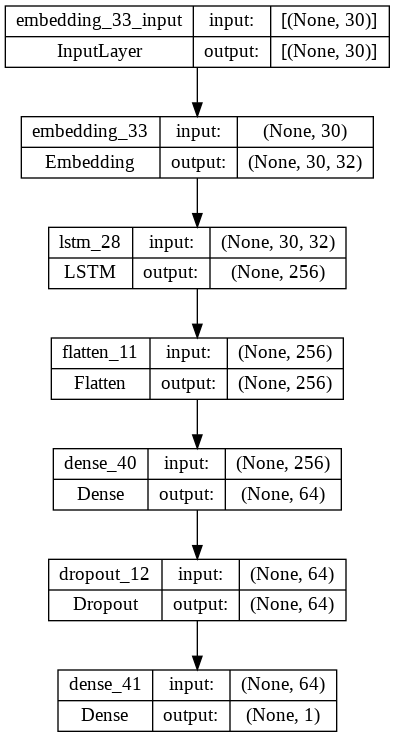

In [127]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

### Choosing the right learning rate using LR-Scheduler

In [128]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

history=model.fit(X_train, np.array(y_train), batch_size=512, epochs=100, callbacks=[lr_scheduler], validation_split=0.1, verbose=2)

Epoch 1/100
633/633 - 7s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5080 - lr: 1.0000e-05 - 7s/epoch - 11ms/step
Epoch 2/100
633/633 - 4s - loss: 0.6930 - accuracy: 0.5051 - val_loss: 0.6928 - val_accuracy: 0.5215 - lr: 1.1220e-05 - 4s/epoch - 7ms/step
Epoch 3/100
633/633 - 4s - loss: 0.6222 - accuracy: 0.6444 - val_loss: 0.5691 - val_accuracy: 0.7035 - lr: 1.2589e-05 - 4s/epoch - 7ms/step
Epoch 4/100
633/633 - 4s - loss: 0.5619 - accuracy: 0.7096 - val_loss: 0.5441 - val_accuracy: 0.7230 - lr: 1.4125e-05 - 4s/epoch - 7ms/step
Epoch 5/100
633/633 - 4s - loss: 0.5425 - accuracy: 0.7254 - val_loss: 0.5295 - val_accuracy: 0.7349 - lr: 1.5849e-05 - 4s/epoch - 7ms/step
Epoch 6/100
633/633 - 4s - loss: 0.5291 - accuracy: 0.7350 - val_loss: 0.5166 - val_accuracy: 0.7426 - lr: 1.7783e-05 - 4s/epoch - 7ms/step
Epoch 7/100
633/633 - 4s - loss: 0.5186 - accuracy: 0.7430 - val_loss: 0.5094 - val_accuracy: 0.7482 - lr: 1.9953e-05 - 4s/epoch - 7ms/step
Epoch 8/100
633/633

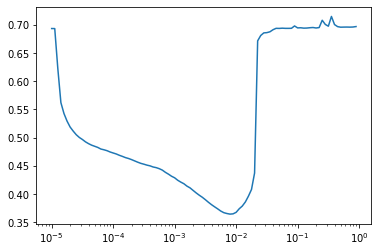

In [129]:
lrs = 1e-5 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])

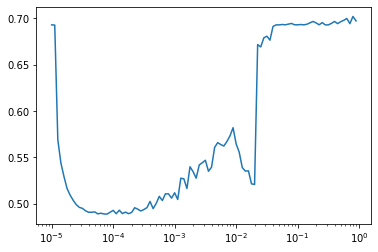

In [130]:
lrs = 1e-5 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['val_loss'])

***The right learning rate for the model above is around 8.0e-5***

In [158]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(LSTM(units=256,  dropout=0.2))
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

## Compile model
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(8.0e-5),
                  metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 30, 32)            320000    
                                                                 
 lstm_40 (LSTM)              (None, 256)               295936    
                                                                 
 flatten_20 (Flatten)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 64)                16448     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total pa

In [159]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

history=model.fit(X_train, np.array(y_train), batch_size=512, epochs=12, validation_split=0.1, verbose=2)

Epoch 1/12
633/633 - 7s - loss: 0.6146 - accuracy: 0.6301 - val_loss: 0.5220 - val_accuracy: 0.7412 - 7s/epoch - 11ms/step
Epoch 2/12
633/633 - 4s - loss: 0.5144 - accuracy: 0.7470 - val_loss: 0.4984 - val_accuracy: 0.7587 - 4s/epoch - 7ms/step
Epoch 3/12
633/633 - 4s - loss: 0.4976 - accuracy: 0.7585 - val_loss: 0.4936 - val_accuracy: 0.7609 - 4s/epoch - 7ms/step
Epoch 4/12
633/633 - 4s - loss: 0.4893 - accuracy: 0.7643 - val_loss: 0.4932 - val_accuracy: 0.7624 - 4s/epoch - 7ms/step
Epoch 5/12
633/633 - 4s - loss: 0.4842 - accuracy: 0.7682 - val_loss: 0.4904 - val_accuracy: 0.7632 - 4s/epoch - 7ms/step
Epoch 6/12
633/633 - 4s - loss: 0.4812 - accuracy: 0.7693 - val_loss: 0.4897 - val_accuracy: 0.7634 - 4s/epoch - 7ms/step
Epoch 7/12
633/633 - 4s - loss: 0.4778 - accuracy: 0.7721 - val_loss: 0.4900 - val_accuracy: 0.7646 - 4s/epoch - 7ms/step
Epoch 8/12
633/633 - 4s - loss: 0.4757 - accuracy: 0.7733 - val_loss: 0.4915 - val_accuracy: 0.7637 - 4s/epoch - 7ms/step
Epoch 9/12
633/633 - 5s

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


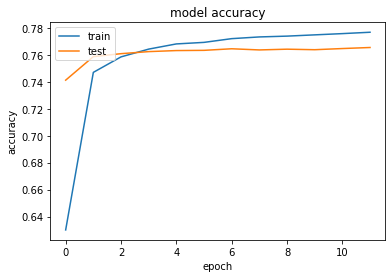

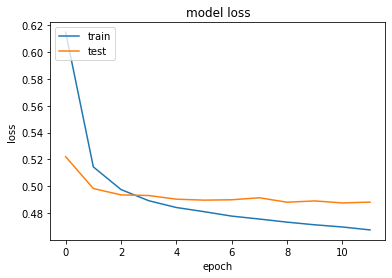

In [160]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model evaluation (single LSTM)

In [161]:
loss, acc = model.evaluate(X_test, np.array(y_test))

print('Test score:', loss)
print('Test accuracy:', acc)
print("Accuracy: %.2f%%" % (acc*100))

1250/1250 [==============================] - 4s 4ms/step - loss: 0.4880 - accuracy: 0.7630
Test score: 0.4880305528640747
Test accuracy: 0.7630000114440918
Accuracy: 76.30%


### Bidirectional LSTM with embedding

In [146]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(64,  dropout=0.2)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

## Compile model
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(8.0e-5),
                  metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 30, 32)            320000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 512)          591872    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              295424    
 nal)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               16512     
                                                                 
 dropout

In [147]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

history=model.fit(X_train, np.array(y_train), batch_size=512, epochs=12, validation_split=0.1, verbose=2)

Epoch 1/12
633/633 - 19s - loss: 0.5734 - accuracy: 0.6842 - val_loss: 0.5065 - val_accuracy: 0.7521 - 19s/epoch - 29ms/step
Epoch 2/12
633/633 - 10s - loss: 0.4919 - accuracy: 0.7633 - val_loss: 0.4925 - val_accuracy: 0.7611 - 10s/epoch - 16ms/step
Epoch 3/12
633/633 - 10s - loss: 0.4787 - accuracy: 0.7720 - val_loss: 0.4908 - val_accuracy: 0.7617 - 10s/epoch - 16ms/step
Epoch 4/12
633/633 - 10s - loss: 0.4739 - accuracy: 0.7752 - val_loss: 0.4898 - val_accuracy: 0.7627 - 10s/epoch - 16ms/step
Epoch 5/12
633/633 - 10s - loss: 0.4709 - accuracy: 0.7772 - val_loss: 0.4902 - val_accuracy: 0.7642 - 10s/epoch - 16ms/step
Epoch 6/12
633/633 - 10s - loss: 0.4687 - accuracy: 0.7785 - val_loss: 0.4918 - val_accuracy: 0.7617 - 10s/epoch - 16ms/step
Epoch 7/12
633/633 - 10s - loss: 0.4670 - accuracy: 0.7793 - val_loss: 0.4907 - val_accuracy: 0.7628 - 10s/epoch - 16ms/step
Epoch 8/12
633/633 - 10s - loss: 0.4660 - accuracy: 0.7801 - val_loss: 0.4902 - val_accuracy: 0.7646 - 10s/epoch - 16ms/step


### Model evaluation (bidirectional LSTM)

In [148]:
loss, acc = model.evaluate(X_test, np.array(y_test))

print('Test score:', loss)
print('Test accuracy:', acc)
print("Accuracy: %.2f%%" % (acc*100))

1250/1250 [==============================] - 9s 7ms/step - loss: 0.4894 - accuracy: 0.7621
Test score: 0.4893818795681
Test accuracy: 0.7620999813079834
Accuracy: 76.21%


***The single LSTM model is slightly better than the bidirectional model on the current dataset. But both models are are not performing very good.***

## Predictions

In [151]:
tokenizer = get_tokenizer(french_sentences)

def predict(sentences, model):
    sentences = preprocess_french(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    ## Text padding
    pad_input_sequences = pad_sequences(sequences, maxlen=X_train.shape[1], padding='post') 
    classes = model.predict(np.array(pad_input_sequences))

    result = {}

    for i in range(len(sentences)): 
        result[sentences[i]]=int(classes[i][0] >= 0.5)
    return result


In [162]:
result = predict(french_sentences[1000:1030], model)
result

1/1 [==============================] - 0s 403ms/step


{'aime faisons effroir autre semaine week end prochain k': 1,
 'réveillé meilleur courriel histoire emails bonne journée': 1,
 'omgah difficile dormir peux faire simulation merci trop': 0,
 'guitares joueurs personnes faisant percussions improvisation objets cuisine heures musique bilingues grande fête autre part': 1,
 'être edison comme être retour école secondaire manque ucf': 0,
 'peux dormir nettoyer place': 0,
 'ça accrochez là bas collines affaires': 1,
 'installés jeu football génial victorieux trouver frustrations place': 1,
 'sais stupide bonne chance leçons apprises': 1,
 'heureux voir autre maman merci suivi': 1,
 'paix nez froids humides apetites voraces quot': 0,
 'souffre manquer petit déjeuner peut penser rien autre nourriture': 0,
 'beaucoup gens connais aussi toujours public gens regardent alors parle effrayant': 1,
 'omg mère vient appeler trop tard parti': 0,
 'aller aventure emily sam drink': 1,
 'vient retirer bijoux nombril toute dernière fois': 0,
 'oui fait trop

In [163]:
print(labels[1000:1030])

[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [164]:
result.values()

dict_values([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

## Conclusion

The final model (single LSTM) generalizes good as the accuracy on train set is around 77.7% and the accurace on test set is around 76.5%. There is no overfitting. However this score is not very high. An improvement could be achieved using attention model.